# PCCM Final Project
## Parallelization of a FE code using OpenMP and MPI
### by Kenny Yung (Matr# 416070)
Due 19 July 2021

## Abstract
In this report, methods for optimizing runtime performance of finite element problem in both serial and parallel fashion are explored. We analyzed the effects of different compiler optimization flags, OpenMP with various threads and scheduling, and MPI with various number of cores. 

The optimal compiler flag found was -O3 -ip which turns on aggressive optimization in sacrifice of longer compilation time and enables additional interprocedural optimizations for single-file compilation. 

For OpenMP, we found that the larger the data set, the better the scalability it has, as the maximum speed-up of fine mesh is more than medium and coarse mesh. The maximum speed-up of all mesh size flattens out around 8 threads where adding additional threads does not yield additional performance. The efficiency also consistently declined as we increase the number of threads. For scheduling, we found that there is no significant difference in performance from the various scheduling methods and chunk size.

For MPI, we found similar characteristics in that the larger the data set, the better the scalability it has. The maximum speed-up of all mesh size declined after 2 cores for coarse mesh and 4 cores for medium and fine mesh where adding additional core yield negative performance. The efficiency also consistently declined as we increase the number of threads.

<br><br><br><br><br><br><br><br><br><br><br><br>

## Introduction

In this project, various methods for optimizing computational mechanic problems are explored to better understand their performance on computational runtimes, and efficiencies. The methods include compiler optimization flags, OpenMP local parallelizations, and MPI distributed memory parallelizations. 

The *Theory and Methods* section gives an overview of the formulas and metrics for measuring performance.

The *Implementation and Validations* section describes the code and how our results are achieved.

The *Results and Discussions* section contains all the findings and detailed relevent discussions on our topics.

The *Conclusion* section gives a summary of our findings.

The *Reference* section includes all the sources and citations that are used in this report.

## Theory and Methods
A finite element (FE) problem basically splits a continuous structure into discrete mesh of individual nodes where each can be calculated using elemental governing equations with boundary conditions from node connectivity. The FE problem being solved is the heat equation on a 2 dimensional rectangular domain $\Omega$ with Dirichlet boundary $\Gamma$ defined as follows from the given pdf [1]:

<center><img,src="equations.png">
    
<P align="left">where $T$ is the temperature, $\kappa$ the thermal diffusivity, and $f$ the thermal heat source. At the domain boundary $\Gamma$ a Dirichlet condition is imposed with temperature TD. The problem is solved for time $t \in (0,t_f)$ using initial condition $T_0$ and final solution time $t_f$.

To analyze the performance of our parallel optimizations, we use the metric of speed-up defined as: 
    
<center>$S_{parallel} = \frac{T_{serial}}{T_{parallel}}$, 
    
and efficiency defined as: 
    
<center>$E_p = \frac{S_p}{p}$, 

where $p$ is the number of parallel threads and $S_p$ is the speed-up of $p$.
    
<br>

## Implementation and Validation
The performance results presented in this report are based on runs executed on the RWTH-Aachen Compute Clusters in July 2021. 

The code provided for the FE problem is written in C++.  

To test performance of compiler optimization flags, the CMakeList is modified to include "*add_compile_options(<-flag>)*" for each optimization flag tested. 

To test performance of OpenMP shared memory optimizitions, various lines of "*#pragma omp parallel for*" and "*schedule(static,128)*" for scheduling type and chunk size are added in front of loops that do large computations. In addition, the number of threads are modified in the batch script that runs on the cluster's Slurm system with the following: "*#SBATCH --cpus-per-task=4*". 

To test performance of MPI distributed memory optimizations, parameters of core/PE numbers and mesh size are adjusted in the batch script.

## Results: Optimization at Compile Time

Table 1: Runtime for solving medium mesh FE problem with various compiler optimization flags (time taken from average of at least 2 runs)

|Optimization Flag|Runtime (s)|
|:--|:-:|
|-O0| 723.63 |
|-O1| 369.08 |
|-O2| 374.95 |
|-O3| 359.48 |
|-fast| 155.51 |
|-ip| 250.22 |
|-ipo| 256.83 |
|-O3 -ip| 155.25 |
|-O2 -fp-model fast=2| 174.04 |
|-fp-model fast=2| 301.41 |
|-axAVX,SSE4.2,SSE4.1| 271.02 |

> As seen in the table, **-O3 -ip** compiler flag gives us the fastest runtime in my experiments.

> A scenario where one would prefer the non-optimized code over the optimized one may be computations that require extremely high precision results since choosing to run the computation in less time may sacrifice precision. 

> Potential drawbacks of using optimization flags include:
> 1. generating a larger executable
> 2. potential bugs that exist only when certain optimization is used
> 3. longer compilation time

Table 2. Description of each optimization flag [2][3]

|Optimization Flag|Description|
|:--|:--|
|-O0| no optimization |
|-O1| some speed optimization |
|-O2| (default) speed optimization |
|-O3| highest optimization, may result in longer compilation times |
|-fast| a simple, but less portable way to get good performance. The -fast option turns on -O3, -ipo, -static and -no-prec-div |
|-ip| enables additional interprocedural optimizations for single-file compilation |
|-ipo| enables interprocedural optimization between files Functions from different files may be inlined |
|-O3 -ip| combination of -O3 and -ip |
|-fp-model fast=2| enables aggressive optimizations of floating-point calculations for execution speed, even those which might decrease accuracy |
|-O2 -fp-model fast=2| combination of -O2 and -fp-model fast=2 |
|-axAVX,SSE4.2,SSE4.1| turns on the automatic vectorizer60 of the compiler and enables code generation for processors which employ the vector operations contained in the AVX2, AVX, SSE4.2, SSE4.1, SSE3, SSE2, SSE, SSSE3 and RDRND instruction set extensions |


## Results: OpenMP
<br>
<center>Table 2: Runtime (s) for OMP-A vs OMP-B
    
| |OpenMP Task A|OpenMP Task B|
|:-:|:-:|:-:|
| **1 thread**| 151.55 | 20.12 |
| **2 thread**| 933.56 | 13.75 |
| **4 thread**| 2007.3 | 13.66 |
    
> After looking at the source code for both solver, I suspect the difference in runtime is due to the *omp critical* regions in the explicit solver method that updates MTnew in a serial way. Since *critical* areas are executed by each thread one at a time, it's actually performaing duplicate work as the number of threads increases which increases runtime. Effectively, there is negative speedup for Task A. Instead, the *reduction* clause can distribute task over all threads and combine the results at the end to successfully parallelize summing task that wouldn't lead to a data race where multiple threads try to write the same shared variable. 
<br>I expected the results for OMP B with a 32% speedup having an additional thread while having no speed-up on 4 threads from using more overhead. However, I did not expect OMP A to have a dramatic increase in runtime going from 1 to 2 and 4 threads. It seems like when there are multiple threads, each thread are doing a lot of waiting.
    
**Investigating scheduling:**

<center>Table 3: Runtime for various scheduling methods and chunk size on fine mesh

|(Scheduling method),(chunk size)|Runtime on 1 thread (s)|Runtime on 4 thread (s)|
|:--|:-:|:-:|
| static, 64 | 1322 | 557.2 |
| static, 128 | 1298 | 543.2 |
| static, 256 | 1305 | 536.3 |
| dynamic, 64 | 1364 | 602.8 |
| dynamic, 128 | 1310 | 565.6 |
| dynamic, 256 | 1365 | 556.7 |
| guided, 64 | 1332 | 547.5 |
| guided, 128 | 1419 | 546.3 |
| guided, 256 | 1379 | 550.4 |
| auto | 1284 | 546.5 |
   
> According to my results, it seems that all the scheduling methods are very similar in performance, with all options averaging around 550 seconds within margin of error. For both static and dynamic scheduling, a larger chunk size works best. For guided scheduling, a smaller chunk size works marginally better. I suspect the reason there is very small variation in performance is because most of the iterations within the loop has equal amount of computational work.
    
> The default scheduling when no *schedule* clause is present is **static** with chunk size equal to #iterations / #threads. The default chunk sizes for static, dynamic, and guided are all 1. [4]
    
For the following, results are using auto scheduling since it provided the fastest runtime as seen from the table above. <br><br>
    
<center>Table 4: Runtime for various number of threads on all 3 mesh

|# of threads | Coarse mesh runtime (s)| Medium mesh runtime (s) | Fine mesh runtime (s) |
|:-:|:-:|:-:|:-:|
| 1 | 21.28 | 200.0 | 1284 |
| 2 | 16.37 | 91.0 | 640 |
| 4 | 12.84 | 76.6 | 546 |
| 6 | 10.75 | 55.7 | 353 |
| 8 | 10.99 | 51.8 | 318 |
| 12 | 11.29 | 50.8 | 309 |
    

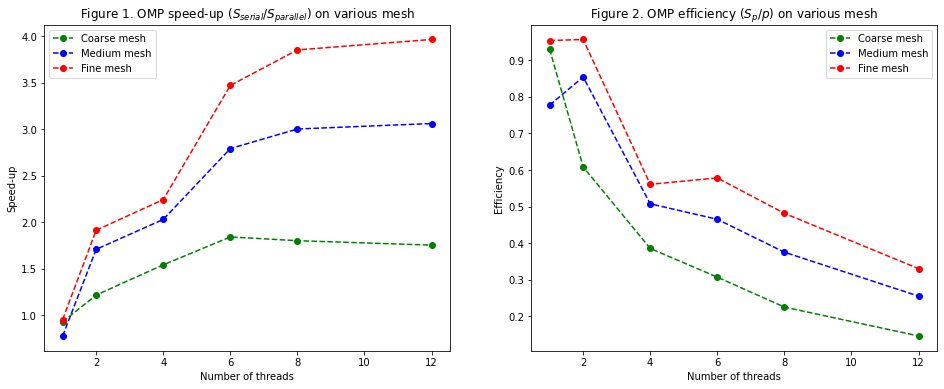

In [20]:
import numpy as np
import matplotlib.pyplot as plt
n_threads = np.array([1,2,4,6,8,12])
t_coarse = np.array([21.28,16.27,12.84,10.75,10.99,11.29])
t_medium = np.array([200,91,76.6,55.7,51.8,50.8])
t_fine = np.array([1284,640,546,353,318,309])
ts_coarse = 19.8
ts_medium = 155.5
ts_fine = 1225
speedup_c = ts_coarse / t_coarse
efficiency_c = speedup_c / n_threads
speedup_m = ts_medium / t_medium
efficiency_m = speedup_m / n_threads
speedup_f = ts_fine / t_fine
efficiency_f = speedup_f / n_threads
# print(min(t_coarse))
# print(min(t_medium))
# print(min(t_fine))
# print(max(speedup_c),max(speedup_m),max(speedup_f))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))
ax1.plot(n_threads,speedup_c,'go--',n_threads,speedup_m,'bo--',
         n_threads,speedup_f,'ro--')
ax2.plot(n_threads,efficiency_c,'go--',n_threads,efficiency_m,'bo--',
         n_threads,efficiency_f,'ro--')
ax1.set_title("Figure 1. OMP speed-up ($S_{serial}/S_{parallel}$) on various mesh")
ax2.set_title('Figure 2. OMP efficiency ($S_p/p$) on various mesh')
ax1.set_xlabel('Number of threads')
ax2.set_xlabel('Number of threads')
ax1.set_ylabel('Speed-up')
ax2.set_ylabel('Efficiency')
ax1.legend(['Coarse mesh','Medium mesh','Fine mesh'])
ax2.legend(['Coarse mesh','Medium mesh','Fine mesh'])
plt.show()

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle code <a href="javascript:code_toggle()">on/off</a>.''')

> As seen from the results, both the speed up and the efficiency increases as the computational data size increases. However, all the different meshes plateaus in performance after around 6 threads. The coarse mesh set cannot go past speed-up of 2, while the medium and fine mesh set cannot go past speed up of around 4. Therefore, increasing number of threads past ~6 will not gain you any significant performance gain. The reason is that as we add more threads, there's a fix amount of overhead computation that negates any gain in performance from having more threads. According to Amdahl's Law, the parallel speed-up to is bounded by $S_p \leq \frac{1}{f + \frac{1-f}{p}}$, where $f$ is the portion that is serial. Because there is less computational work compare to the fixed serial overhead, generally the finer the mesh the higher the theoretical maximum speed-up is.
    

## Results: MPI (Message Passing Interface)
<br>
<center>Table 5: Runtime for various number of cores/PEs on all 3 mesh

|# of cores | Coarse mesh runtime (s)| Medium mesh runtime (s)| Fine mesh runtime (s)|
|:-:|:-:|:-:|:-:|
| 1 | 26.40 | 220.0 | 1427 |
| 2 | 19.34 | 116.7 | 778 |
| 4 | 23.68 | 105.8 | 483 |
| 6 | 34.84 | 117.6 | 526 |
| 8 | 49.92 | 140.3 | 551 |
| 12 | 91.0 | 200.1 | 639 |
| 16 | 117.0 | 240.2 | 778 |

    

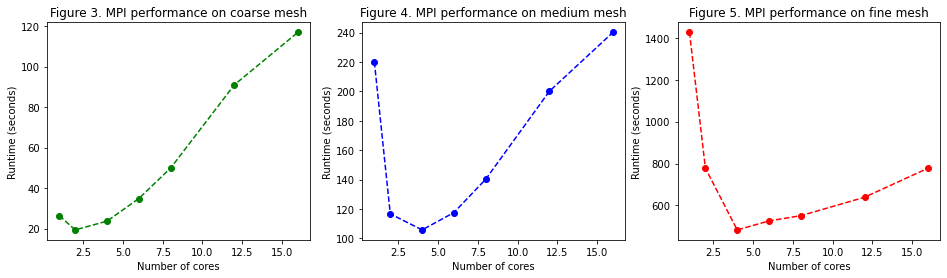

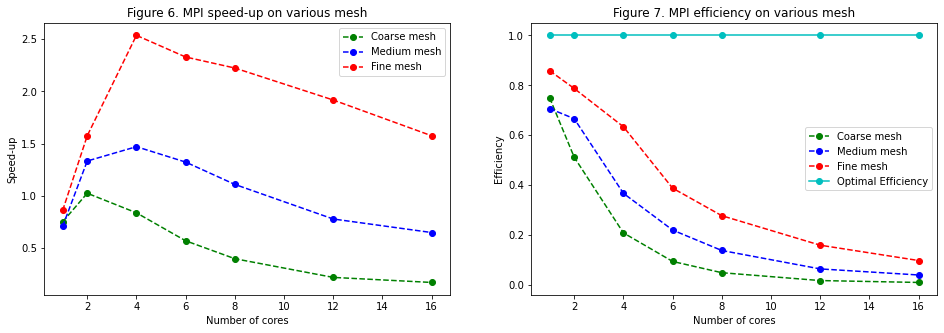

In [24]:
# import matplotlib.pyplot as plt
n_core = np.array([1,2,4,6,8,12,16])
t_coarse = np.array([26.40,19.34,23.68,34.84,49.92,91.0,117.0])
t_medium = np.array([220.0,116.7,105.8,117.6,140.3,200.1,240.2])
t_fine = np.array([1427,778,483,526,551,639,778])
ts_coarse = 19.8
ts_medium = 155.5
ts_fine = 1225
speedup_c = ts_coarse / t_coarse
speedup_m = ts_medium / t_medium
speedup_f = ts_fine / t_fine
efficiency_c = speedup_c / n_core
efficiency_m = speedup_m / n_core
efficiency_f = speedup_f / n_core
# print(min(t_coarse))
# print(min(t_medium))
# print(min(t_fine))
# print(max(speedup_c),max(speedup_m),max(speedup_f))
# print(min(efficiency_c),min(efficiency_m),min(efficiency_f))
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,4))
ax1.plot(n_core,t_coarse,'go--')
ax1.set_title('Figure 3. MPI performance on coarse mesh')
ax1.set_xlabel('Number of cores')
ax1.set_ylabel('Runtime (seconds)')
ax2.plot(n_core,t_medium,'bo--')
ax2.set_title('Figure 4. MPI performance on medium mesh')
ax2.set_xlabel('Number of cores')
ax2.set_ylabel('Runtime (seconds)')
ax3.plot(n_core,t_fine,'ro--')
ax3.set_title('Figure 5. MPI performance on fine mesh')
ax3.set_xlabel('Number of cores')
ax3.set_ylabel('Runtime (seconds)')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,5))
ax1.plot(n_core,speedup_c,'go--',n_core,speedup_m,'bo--',n_core,speedup_f,'ro--')
ax1.set_title('Figure 6. MPI speed-up on various mesh')
ax1.set_xlabel('Number of cores')
ax1.set_ylabel('Speed-up')
ax2.plot(n_core,efficiency_c,'go--',n_core,efficiency_m,'bo--',
         n_core,efficiency_f,'ro--',n_core,np.ones(7),'co-')
ax2.set_title('Figure 7. MPI efficiency on various mesh')
ax2.set_xlabel('Number of cores')
ax2.set_ylabel('Efficiency')
ax1.legend(['Coarse mesh','Medium mesh','Fine mesh'])
ax2.legend(['Coarse mesh','Medium mesh','Fine mesh','Optimal Efficiency'])
plt.show()

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle code <a href="javascript:code_toggle()">on/off</a>.''')

> In a perfectly parallelized code, each additional core/PE will have the same amount of gain in speed-up, where the parallel efficiency will stay at 1. Graphically, the speed-up will look like a straight increasing line, and efficiency will be a constant straight line. However, that is an idealistic scenario since there is always overhead where parts of the code that is done serially. In MPI, there is time "wasted" when each node waits to send or receive the data needed from another node. According to Amdahl's Law, we should then expect the parallel speed-up to be bounded by $S_p \leq \frac{1}{f + \frac{1-f}{p}}$ if the non-serial code is perfectly scalable, where $f$ is the portion that is serial. <br><br>
In the graphs above, we can see the above mentioned effects as increasing the number of cores will only increase performance to a certain point, where it will start to worsen it. The coarse mesh set has a slower performance after 2 cores, while both the medium and fine mesh set slowed after 4 cores. See table 6 below for detailed statistics. It can also be said that our code is not very scalable, seeing that instead of plateauing according to Amdahl's Law, the speed-up actually curves back down. <br><br>
Because of the nature of communication durations and overhead, each additional core decreases the efficiency as well. For the optimal performance, I would choose 2 threads for coarse mesh and 4 threads for both medium and fine mesh because it yields the fastest runtimes - which is the goal of parallization - and does not use unnecessary resources. 

<center>Table 6. Comparison of MPI performance on various threads

| |Coarse mesh|Medium mesh|Fine mesh|
|:-:|:-:|:-:|:-:|
| Maximum speed-up | 1.02 | 1.47 | 2.54 |
| Minimum efficiency | 0.011 | 0.040 | 0.098 |

<br>
<center>Figure 8. Partitions of the medium mesh with 8 cores using Paraview
<img src="paraview.png">

> Here in figure 8 is the provided partitioning for each core/PE. I believe it is a good partitioning because it mimizes areas where it interfaces with other PEs, which increases runtime. The reason more interfaces with other PEs lead to increased runtime is because passing data from one to another takes time and cause latency with send/receive operations which also uses more computational resources. It is crucial to group areas of computation together for the maximum performance. If points within a partition is scattered across the area, there will be significantly more data it must gather from other PEs and wait for send/receive to complete. 
    
> *I) Reason to use MPI_Accumulate in the code instead of MPI_Put* <br>MPI_Put is a one-sided send operation where the receiving PE does not have to be involved. MPI_Accumulate is similar to MPI_Put, except that data is combined into the target area instead of overwriting it. [5] I believe the reason MPI_Accumulate is used over MPI_Put is because we want to prevent other PEs from overwriting the data sent from another PE if there is the scenario where multiple PEs send data to the same target PE.
<br><br>*II) Advantages of using one-sided MPI communication over two-sided MPI communication* <br>One sided MPI communication can accomplish the same task of sending and receiving data without unnecessary extra work and risk of two-sided MPI communication problems such as [6]: <br>
    - potential of deadlock where sender is waiting for the receiver's confirmation <br>
    - excessive synchronization or handshaking that increases runtime <br>
    - excessive data copying that increases runtime
<br><br>*III) Advantage of MPI over OpenMP and the main obstacle of MPI* <br>Since OpenMP is a shared memory parallelization vs MPI which is a distributed memory parallization, it is inherently limited to the size of the computing architecture. MPI is able to scale well with modern supercomputer clusters consisting of many nodes of independent memory. In order to implement OpenMP over large amounts of nodes, they would have to have a unified memory architecture which is much harder to do so with problems of latency and accessibility. In general, OpenMP is suitable for parallelizing a local nodes, whereas MPI is suitable to parallelizing a system of nodes. The main obstacle of MPI is data management since there are massive amount of data being sent and received from another node for data-dependent codes. Much more attention has to be given to prevent slowdown or even stalls during runtime in MPI. It is also limited by the communication network between nodes. Consequently, MPI can be harder to debug, while OpenMP is easier.
    
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## Conclusion
<br>
<center>Table 7. Fastest performance of explored parallel optimizations on various mesh size

| |Coarse mesh|Medium mesh|Fine mesh|
|:-:|:-:|:-:|:-:|
| OpenMP runtime (s) | 309 | 50.8 | 10.75 |
| OpenMP speed-up | 1.84 | 3.06 | 3.96 |
| MPI runtime (s) | 483 | 105.8 | 19.34 |
| MPI speed-up | 1.02 | 1.47 | 2.54 |

Above is the summary of peak performance of the parallization methods explored. It should be noted that for our specific finite element problem, OpenMP is much more scalable than MPI since adding more threads past the optimum did not yield adverse performance, unlike MPI where using more cores past the optimum decreases the performance. Seeing that OpenMP performed better than MPI across all the data sets, one may conclude that OpenMP is much better choice for parallel optimization. However, the 2 methods are not mutually exclusive and can be combined to use together with OpenMP within local nodes and MPI across the cluster. This way, one can take advantage of both methods of parallelization. Therefore, one suggestion for the code developer to improve performance is to explore implementing OpenMP and MPI in the same code. 

## References

[1] Parallel Computing for Computational Mechanics Summer semester 2021 Final Project - Parallelization of a FE code using OpenMP and MPI -Marek Behr, Michael Make, Maximilian Schuster

[2] The RWTH HPC-Cluster User's Guide (Version 8.4.0)
    Release: July 2016
    Build: September 26, 2016
    -Dieter an Mey, Christian Terboven, Paul Kapinos, Dirk Schmidl, Sandra Wienke, Tim Cramer
    
[3] Intel® C++ Compiler Classic Developer Guide and Reference
"https://software.intel.com/content/www/us/en/develop/documentation/cpp-compiler-developer-guide-and-reference/top/compiler-reference/compiler-options.html"9

[4] http://jakascorner.com/blog/2016/06/omp-for-scheduling.html

[5] https://www.open-mpi.org

[6] Lecture 13 slides of Parallel Computing for Computational Mechanics Summer semester 2021 


<img src="" alt="">